In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras

from IPython.display import clear_output

In [2]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, metrics=[]):
        self.print_metrics = metrics

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(len(metrics)//2 +1 , 2, figsize=(20,10))
        
        clear_output(wait=True)
        axs = list(np.array(axs).flatten())

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric],
                        label=metric)
            
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([min(min(history.history['loss']), min(history.history['loss']))*0.8, max(max(history.history['loss']), max(history.history['loss']))*1.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [monthly spend]')
    plt.legend()
    plt.grid(True)

In [5]:
# Carrega os dados e define o objetivo: Cliente compliante, aquele que paga suas faturas corretamente
dataset = pd.read_json('train_data.json')
dataset = dataset.drop(columns = ['monthly_spend', 'profit', 'time_as_client'])

target = 'compliant'

# Agora temos uma previsão de gasto de cada cliente, podendo utilizá-la como feature no resultado final
m_spend_model = tf.keras.models.load_model('m_spend_regressor.dnn')
m_spend_data = dataset.copy().drop(target,axis=1)

# Usando as predições como variável explicativa
dataset['monthly_spend'] = m_spend_model.predict(m_spend_data).flatten()

256/256 [==============================] - 0s 609us/step


In [6]:
# Separa em treino e validação
train_dataset = dataset.sample(frac=0.9, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
# Separa em features e labels (objetivo)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

features = test_features.columns.drop(target)

train_labels = train_features.pop(target)
test_labels = test_features.pop(target)

# Define uma camada de normalização
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [8]:
# Definição de um modelo
def build_and_compile_model(norm):
    
    # Ativações não lineares (relu) e lineares
    model = keras.Sequential([
        norm,
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(16, activation="tanh"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    # Define o schedule da taxa de aprendizagem, começando com 0.5 e decaindo exponencialmente
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(1e-3,
                                                                 decay_steps = 1000,
                                                                 decay_rate=10,
                                                                 staircase=False)

    # Compila o modelo com o objetivo Binary Crossentropy, com métricas adicionais
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  loss="binary_crossentropy", metrics=[tf.keras.metrics.Precision(),
                                                       tf.keras.metrics.Recall(),
                                                       tf.keras.metrics.FalseNegatives(),
                                                       tf.keras.metrics.FalsePositives(),
                                                       tf.keras.metrics.TrueNegatives(),
                                                       tf.keras.metrics.TruePositives()])
    model.save_weights('initial_compliant_model.h5')
    
    return model

In [9]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 22)               45        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                736       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                        

In [10]:
metrics_to_plot = ['loss', 'precision', 'recall', 'true_positives']

callbacks_list = [PlotLearning(metrics_to_plot),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   verbose=1,
                                                   min_delta=1e-4,
                                                   patience=25,
                                                   restore_best_weights=True)]

dnn_model.load_weights('initial_compliant_model.h5')

26/26 [==============================] - 0s 633us/step


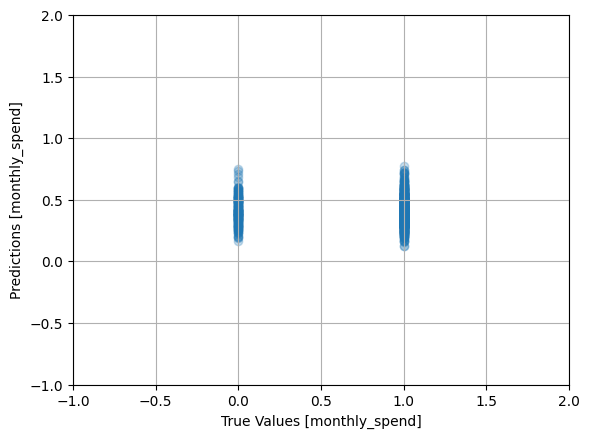

In [16]:
dnn_model.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.25)
plt.xlabel('True Values [monthly_spend]')
plt.ylabel('Predictions [monthly_spend]')
lims = [-1,2]
plt.xlim(lims)
plt.ylim(lims)
plt.grid()


### Treinando uma rede

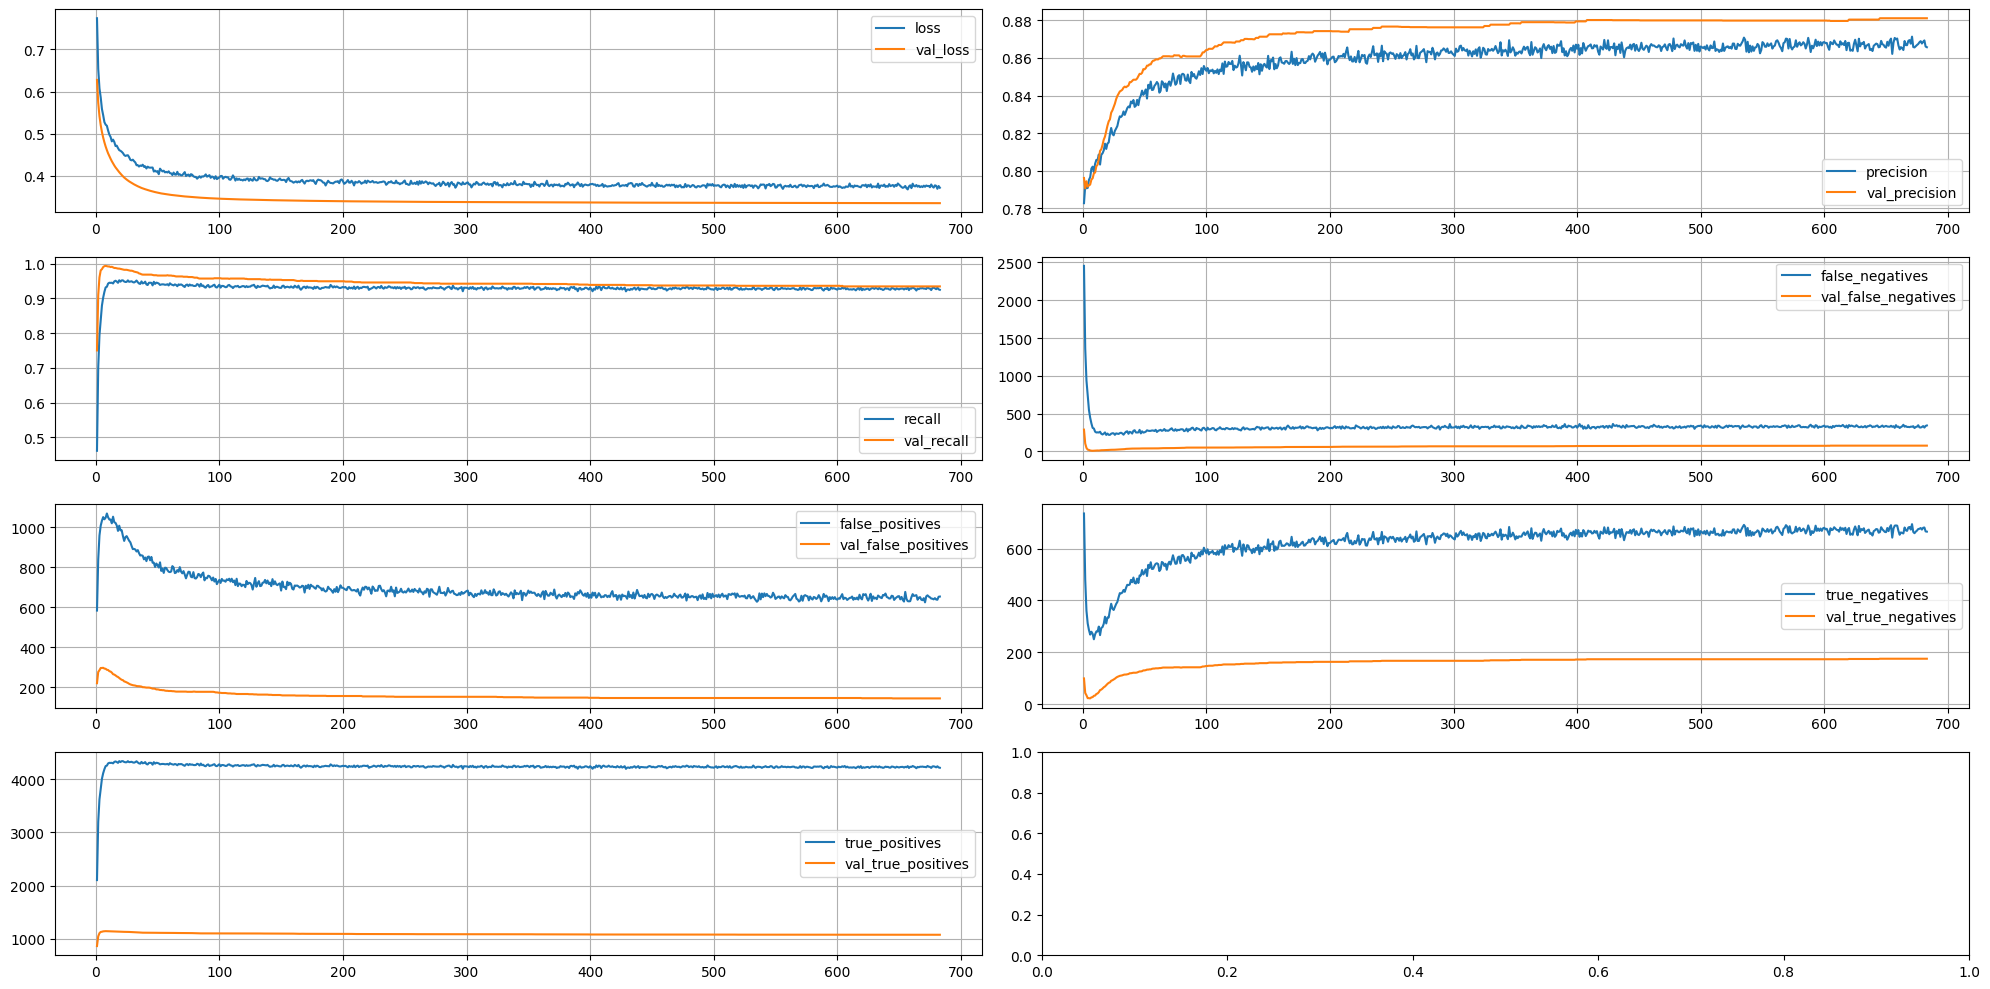

Restoring model weights from the end of the best epoch: 658.
184/184 [==============================] - 1s 6ms/step - loss: 0.3711 - precision: 0.8657 - recall: 0.9250 - false_negatives: 342.0000 - false_positives: 654.0000 - true_negatives: 665.0000 - true_positives: 4217.0000 - val_loss: 0.3344 - val_precision: 0.8811 - val_recall: 0.9348 - val_false_negatives: 75.0000 - val_false_positives: 145.0000 - val_true_negatives: 175.0000 - val_true_positives: 1075.0000
Epoch 683: early stopping
CPU times: user 13min 9s, sys: 2min 44s, total: 15min 54s
Wall time: 12min 11s


In [18]:
%%time

metrics_to_plot = ['loss', 'precision', 'recall', 'true_positives']

callbacks_list = [PlotLearning(metrics_to_plot),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   verbose=1,
                                                   min_delta=1e-4,
                                                   patience=25,
                                                   restore_best_weights=True)]

dnn_model.load_weights('initial_compliant_model.h5')
history = dnn_model.fit(train_features, 
                        train_labels, 
                        validation_split=0.2,
                        verbose=1, 
                        epochs=1000,
                        callbacks=callbacks_list,
                        class_weight = {0:0.22, 1:0.78})

In [19]:
dnn_model.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features).flatten()


26/26 [==============================] - 0s 654us/step


In [20]:
dnn_model.metrics

In [37]:
false_negatives = dnn_model.metrics[-4].result().numpy()
false_positives = dnn_model.metrics[-3].result().numpy()
true_negatives = dnn_model.metrics[-2].result().numpy() 
true_positives = dnn_model.metrics[-1].result().numpy()
print("True Positives", true_positives)

T = false_negatives + false_positives + true_negatives + true_positives
T

True Positives 572.0


816.0

In [42]:
# Taxa de aceitação do cartão
print(f"Taxa de aceitação: {(true_positives+false_positives)*100/T :.2f}%")

# Nova taxa de adimplência
print(f"Taxa de adimplência: {true_positives*100/(true_positives+false_positives) :.2f}%")

Taxa de aceitação: 79.78%
Taxa de adimplência: 87.86%


In [26]:
# Pega o dataset de teste com predições de gasto mensal
original_test_dataset = pd.read_json('test_data_month_pred.json')

In [29]:
# Separa em features e objetivo
test_dataset_features = original_test_dataset[features]
test_dataset_target = original_test_dataset[[target]].copy()

In [30]:
# Computa as predições de adimplência
predictions = dnn_model.predict(test_dataset_features).flatten()
predictions = [int(np.round(i,0)) for i in predictions]
original_test_dataset['predictions'] = predictions

# Calcula o lucro esperado de um cliente com a predição de gasto mensal e predição de inadimplência
original_test_dataset['predicted_profit'] = (original_test_dataset['time_as_client']*original_test_dataset['predicted_monthly_spend']*0.02 - (1-original_test_dataset['predictions'])*original_test_dataset['predicted_monthly_spend'])

# Mostra 10 pontos do dataset
original_test_dataset[[target, 'predictions', 'monthly_spend', 'predicted_monthly_spend', 'profit', 'predicted_profit']].sample(10)


32/32 [==============================] - 0s 606us/step


,compliant,predictions,monthly_spend,predicted_monthly_spend,profit,predicted_profit
1339,1,1,275,814.186890,561.00,1660.941255
3260,1,1,1140,427.559418,205.20,76.960695
3086,1,1,685,938.344971,1397.40,1914.223740
1739,0,0,305,454.054138,-189.10,-281.513566
3734,1,1,202,986.884583,412.08,2013.244548
3168,1,1,3212,1013.937927,6552.48,2068.433372
7612,1,0,257,1243.734375,524.28,1293.483750
7270,1,1,158,210.048035,322.32,428.497991
1320,1,1,931,1026.192505,1899.24,2093.432710
27,1,1,180,378.755005,367.20,772.660210


In [32]:
# Regra final: Aprovar Clientes com Lucro predito positivo
approved_clients = original_test_dataset[original_test_dataset.predicted_profit > 0].copy()

In [33]:
# Cálculo do lucro por cliente antes da regra de aprovação
original_profit_per_client = original_test_dataset['profit'].mean()

# Calculo do novo lucro por cliente após regra de aprovação do cartão
total_profit_per_client = approved_clients['profit'].mean()

print(f'Lucro por cliente sem classificação = {original_profit_per_client:.2f}')
print(f'Lucro por cliente após uso dos modelos de predição = {total_profit_per_client:.2f}')
print(f'Melhoria: {(total_profit_per_client-original_profit_per_client)*100/(original_profit_per_client):.2f}%')

Lucro por cliente sem classificação = 1300.76
Lucro por cliente após uso dos modelos de predição = 1547.54
Melhoria: 18.97%


In [34]:
dnn_model.save('best_compliant_classifier.dnn')

INFO:tensorflow:Assets written to: best_compliant_classifier.dnn/assets


INFO:tensorflow:Assets written to: best_compliant_classifier.dnn/assets


In [35]:
len(approved_clients)

896

In [43]:
total_profit = approved_clients['profit'].sum()
original_profit = original_test_dataset['profit'].sum()

In [57]:
print(f"Lucro original em 1000 pedidos: {original_profit :.2f}")
print(f"Lucro total após novo modelo: {total_profit :.2f}")
print(f'Melhoria no lucro total: {total_profit-original_profit :.2f} -- {(total_profit-original_profit)*100/original_profit:.2f}%')


Lucro original em 1000 pedidos: 1300759.56
Lucro total após novo modelo: 1386595.40
Melhoria no lucro total: 85835.84 -- 6.60%
